# Binary Logistic Regression From Sratch!
### Cara Mulrooney & Maya Cranor

Binary logistic regression is a supervised learning technique that employs mathematics to establish the connections between a dependent binary output variable (usually coded as 0 or 1) and one or more independent input variables, which can be nominal, ordinal, interval, or ratio-level. This approach then uses these relationships to estimate the likelihood that the binary variable falls into a specific class, given the values of the independent variables. In classification tasks, a common practice is to set the probability threshold to 0.5. This means that if the predicted probability of a data point is equal to or greater than 0.5, it is assigned to class 1; otherwise, it is assigned to class 0. 

Let's start by creating a random dataset to later classify using our logistic regression model.

In [2]:
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit, logit
from sklearn.linear_model import LogisticRegression
import matplotlib.patches as mpatches
import time
import pandas as pd 
import seaborn as sns
from  sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## Creating a Random Simulated Test Data Set

In [3]:
# Create starting input for numpy's pseudo-random generator
np.random.seed(12)
num_observations = 4000

# Generates two sets of random observations (x1 and x2) from multivariate normal distributions with specific means and covariance matrices
x1 = np.random.multivariate_normal([0, 0], [[1, .75],[.75, 1]], num_observations)
x2 = np.random.multivariate_normal([1, 4], [[1, .75],[.75, 1]], num_observations)

# Stack x1 and x2 vertically to make a single array
simulated_separableish_features = np.vstack((x1, x2)).astype(np.float32)
# Create a list of labels (0 or 1) for simulated_separable_features
simulated_labels = np.hstack((np.zeros(num_observations), np.ones(num_observations)))

Text(0.5, 1.0, 'Randomly Generated Data')

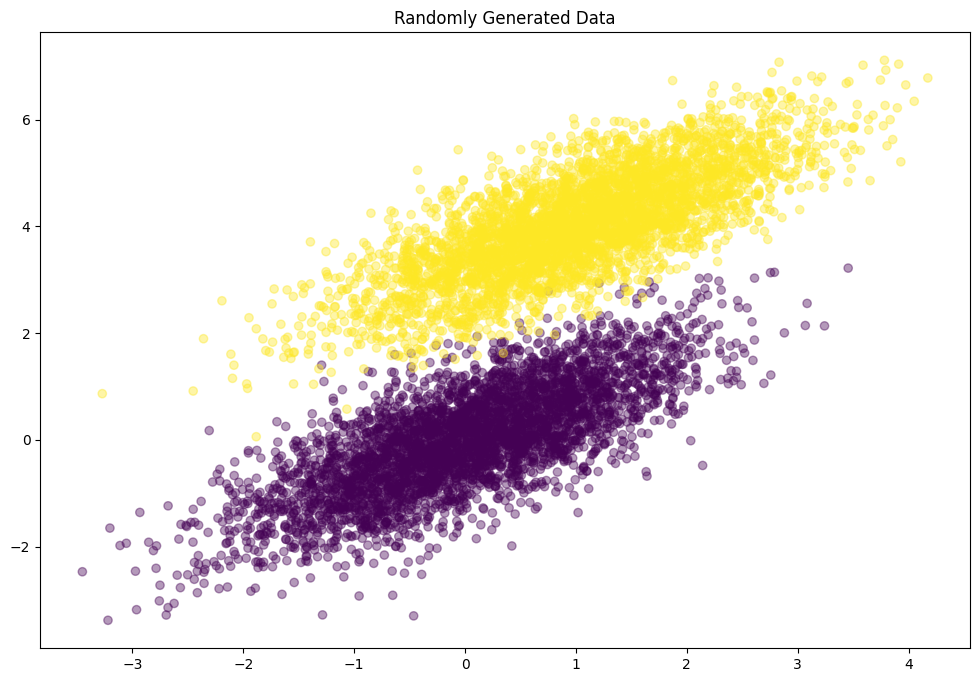

In [4]:
# Plot the random data set
plt.figure(figsize=(12,8))
plt.scatter(simulated_separableish_features[:, 0], simulated_separableish_features[:, 1],
            c = simulated_labels, alpha = .4)
plt.title("Randomly Generated Data")

### How Binary Logistic Regression Works
Binary logistic regression relies on the logistic function, also known as the sigmoid function, an S-shaped curve that takes a real-valued number as an input and maps it to an output value between 0 and 1, exclusively. The logistic function is shown in Equation (1).
$$
y = {1 \over (1+e^{-x})} \tag{1}
$$

The logistic regression algorithm employs the logistic function equation to predict binary output values by combining input values linearly using weights. The logistic regression equation, as expressed in Equation (2), encapsulates this process. 

$$
P = {1 \over (1+e^{-(\beta_{0}+\beta_{1}*x)})} \tag{2}
$$

where $P$ is the predicted output, $\beta_{0}$ is the intercept tem, and $\beta_{1}$ is the coefficient for the input value, $x$. 

As seen in the above equation, each input value has an associated coefficient. These coefficients are constant values estimated from training data using maximum-likelihood estimation (MLE). The log-likelihood function, depicted in Equation (3), optimizes these coefficients to minimize the error in the predicted class probabilities and the actual class labels in the training data. 

$$
l(\beta) = \Sigma^{n}_{i=1} y_i \beta x_i - log(1+e^{\beta x_i}) \tag{3}
$$

This optimization process involves a loss function, which quantifies how well the model is performing by measuring the difference between its predictions and the actual outcomes. Techniques, such as gradient descent, are commonly applied to iteratively adjust the coefficients in the direction that maximizes the log-likelihood, the MLE loss function, enhancing the model’s predictive accuracy. 
In gradient descent, the gradient of the log-likelihood function with respect to the coefficients is computed, which indicates the direction in which the function is the steepest. The coefficients are then adjusted in the opposite direction of the gradient to move towards the maximum likelihood. The process is repeated iteratively until convergence, where the changes in the log-likelihood become small, indicating that the algorithm has found optimal coefficients. The learning rate in gradient descent controls the size of the steps taken during each iteration, balancing convergence speed and stability.


### Logistic Regression Implementation

In [5]:
def sigmoid(scores: np.ndarray) -> np.ndarray:
    """
    Calculate the sigmoid function for a given set of scores.

    Parameters:
    - scores (numpy.ndarray): An array of real-valued scores.

    Returns:
    - numpy.ndarray: An array of values between 0 and 1, representing the sigmoid
                    transformation of the input scores.
    """
    return 1 / (1 + np.exp(-scores))

In [6]:
def log_likelihood(features: np.ndarray, target: np.ndarray, weights: np.ndarray) -> float:
    """
    Calculate the log-likelihood of logistic regression.

    Parameters:
    - features (numpy.ndarray): Input features, represented as a 2D array.
    - target (numpy.ndarray): Binary target variable, represented as a 1D array.
    - weights (numpy.ndarray): Coefficients (weights) associated with each feature.

    Returns:
    - float: Log-likelihood value for the given logistic regression model.
    """
    # Calculate the dot product of features and weights to get the scores
    scores = np.dot(features, weights)
    
    # Calculate the log-likelihood using the logistic regression formula
    log_likelihood = np.sum(target * scores - np.log(1 + np.exp(scores)))
    
    return log_likelihood

In [7]:
def logistic_regression(features: np.ndarray, target: np.ndarray, num_steps: int, learning_rate: float, add_intercept=False)-> np.ndarray:
    """
    Perform logistic regression using gradient descent.

    Parameters:
    - features (np.ndarray): Input features, represented as a 2D array.
    - target (np.ndarray): Binary target variable, represented as a 1D array.
    - num_steps (int): Number of steps (iterations) for gradient descent.
    - learning_rate (float): Step size for each iteration of gradient descent.
    - add_intercept (bool, optional): Flag to indicate whether to add an intercept term. Default is False.

    Returns:
    - numpy.ndarray: Coefficients (weights) for the logistic regression model.
    """
    # Add intercept term to features if specified
    if add_intercept:
        intercept = np.ones((features.shape[0], 1))
        features = np.hstack((intercept, features))

    # Initialize weights to zeros
    weights = np.zeros(features.shape[1])

    # Perform gradient descent for the specified number of steps
    for step in range(num_steps):
        # Calculate scores and predictions using current weights
        scores = np.dot(features, weights)
        predictions = sigmoid(scores)

        # Update weights using gradient descent
        output_error_signal = target - predictions
        gradient = np.dot(features.T, output_error_signal)
        weights += learning_rate * gradient

        # Print log-likelihood every 10,000 steps for monitoring
        if step % 10000 == 0:
            print(log_likelihood(features, target, weights))

    return weights

In [17]:
start_time = time.time()

# Split data into train and test sets
X_train_scratch, X_test_scratch, y_train_scratch, y_test_scratch = train_test_split(
    simulated_separableish_features, simulated_labels, test_size=0.2, random_state=42
)

weights = logistic_regression(X_train_scratch, y_train_scratch,
                               num_steps=300000, learning_rate=5e-5, add_intercept=True)
end_time = time.time()
scratch_time = end_time - start_time
print(f"Execution time: {scratch_time} seconds")

-3045.592435358139
-88.13172310723256
-80.96887074226888
-78.57430368886217
-77.46398089245895
-76.86811642650292
-76.52053601552426
-76.30661199185772
-76.16997140460914
-76.08031097948403
-76.0202747235667
-75.97944261883237
-75.95132923910123
-75.93178270453852
-75.91808483981646
-75.90842371183155
-75.90157363724825
-75.89669546457058
-75.89320894061208
-75.8907095108352
-75.88891317149135
-75.88761939613896
-75.886685913007
-75.88601136990042
-75.88552331680316
-75.88516981349079
-75.88491353188314
-75.88472758937506
-75.88459259167546
-75.88449452589384
Execution time: 67.69833517074585 seconds


## Results

In [26]:
# Adding a column of ones to the simulated features to account for the intercept term
data_with_intercept = np.hstack((np.ones((X_test_scratch.shape[0], 1)), X_test_scratch))

# Calculating the final scores by taking the dot product of the data with intercept and the weights
final_scores = np.dot(data_with_intercept, weights)

# Applying the sigmoid function to the final scores and rounding the result to obtain predictions
prediction = np.round(sigmoid(final_scores))

conf_matrix_scratch = confusion_matrix(y_test_scratch, prediction)
classification_rep_scratch = classification_report(y_test_scratch, prediction)

print (f'Accuracy from scratch: {accuracy_score(y_test_scratch, prediction)}')

Accuracy from scratch: 0.996875


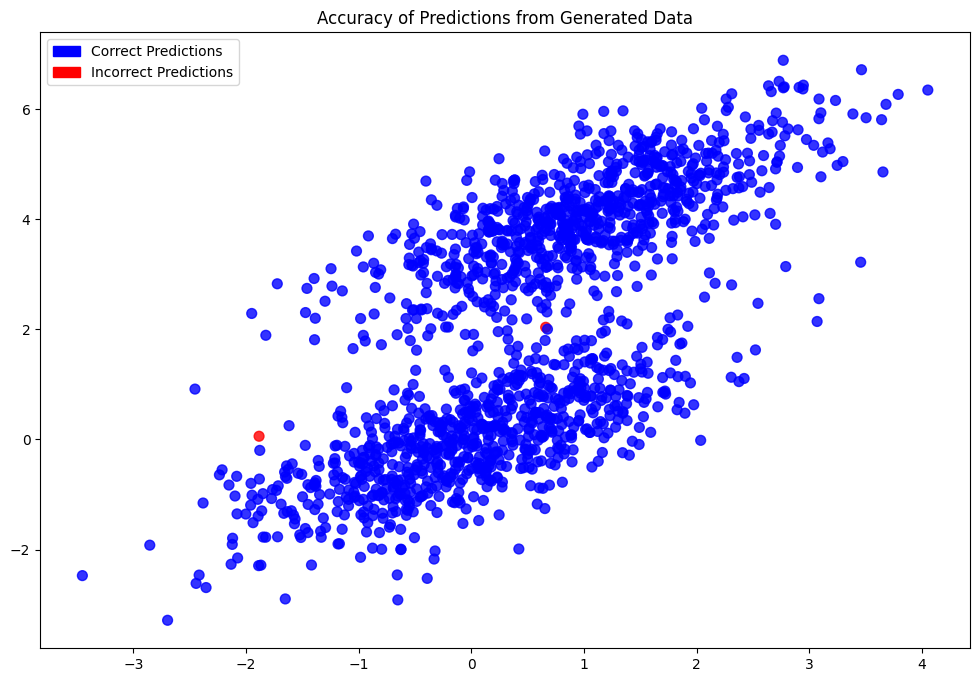

In [24]:
plt.figure(figsize=(12, 8))

# Scatter plot with blue dots for correct predictions and red dots for incorrect predictions
plt.scatter(X_test_scratch[:, 0], X_test_scratch[:, 1],
            c=np.where(prediction == y_test_scratch - 1, 'red', 'blue'), alpha=.8, s=50)

plt.title("Accuracy of Predictions from Generated Data")
# Create a legend
blue_patch = mpatches.Patch(color='blue', label='Correct Predictions')
red_patch = mpatches.Patch(color='red', label='Incorrect Predictions')
plt.legend(handles=[blue_patch, red_patch])
plt.show()

## Comparison with Sk-Learn’s LogisticRegression

In [28]:
start_time = time.time()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(simulated_separableish_features, simulated_labels, test_size=0.2, random_state=42)

# Creating Sk-Learn's Logistic Regression classifier without L2 regularization
clf = LogisticRegression(fit_intercept=True, C=1e15)

# Running simulated data on the classifier
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)


end_time = time.time()
sklearn_time = end_time - start_time

# Weights
print ("Weights from scratch algorithm:     ",weights)
print ("Weights from Sk-Learn’s algorithm:  ",clf.intercept_, clf.coef_)

# Execution Time
print(f"Scratch's execution time: {scratch_time} seconds")
print(f"SK-learn's execution time: {sklearn_time} seconds")

# Accuracy
print (f'Accuracy From Scratch: {accuracy_score(y_test_scratch, prediction)}')
print(f"Confusion Matrix From Scratch:\n{conf_matrix_scratch}")
print(f"Classification Report From Scratch:\n{classification_rep_scratch}")

print (f'Accuracy From Sk-learn: {accuracy_score(y_test, y_pred)}')
print(f"Confusion Matrix From Sk-learn:\n{conf_matrix}")
print(f"Classification Report From Sk-learn:\n{classification_rep}")

Weights from scratch algorithm:      [-15.52508287  -5.43843234   8.90813006]
Weights from Sk-Learn’s algorithm:   [-15.55406385] [[-5.44824565  8.92428291]]
Scratch's execution time: 67.69833517074585 seconds
SK-learn's execution time: 0.06505179405212402 seconds
Accuracy From Scratch: 0.996875
Confusion Matrix From Scratch:
[[801   3]
 [  2 794]]
Classification Report From Scratch:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       804
         1.0       1.00      1.00      1.00       796

    accuracy                           1.00      1600
   macro avg       1.00      1.00      1.00      1600
weighted avg       1.00      1.00      1.00      1600

Accuracy From Sk-learn: 0.996875
Confusion Matrix From Sk-learn:
[[801   3]
 [  2 794]]
Classification Report From Sk-learn:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       804
         1.0       1.00      1.00      1.00       79

As seen in the comparison above, the weights of both algorithms are nearly identical. If the algorithm developed from scratch were executed with a slightly lower learning rate, the weights would align precisely. Despite the minor differences in weights, both algorithms yield identical accuracy scores and confusion matrices. Please note, the algorithm developed from scratch, while achieving equivalent accuracy, takes considerably more time compared to Sk-learn's implementation. This time difference might stem from additional optimizations incorporated into the pre-built model.

### Logistic Regression Example

We could predict whether a student passes or fails an exam based on the number of hours they studied using logistic regression. This algorithm is suitable in this situation, since there is a nominal independent variable--the number of hours a student studied--and a dependent target variable--the binary outcome indicating whether the student passed (1) or failed (0). Suppose we have a dataset containing student information, where each data point includes these two variables. Our goal then is to build a logistic regression model that can predict the probability of a student passing the exam based on the number of hours they studied. The logistic regression equation for this scenario is shown below.

$$
P(Y=1) = {1 \over (1+e^{-(\beta_{0}+\beta_{1}*x)})}
$$

where $Y$ is the binary outcome (pass or fail), $x$ is the number of hours studied, and $\beta_0$ and $\beta_1$ are the coefficients to be determined during the training process.

The model is then trained on the student dataset with known binary outcomes and corresponding hours studied. The logistic regression algorithm adjusts the coefficients ($\beta_0$ and $\beta_1$) using the maximum-likelihood estimation technique for optimization.

Once trained, the model can predict the probability of a student passing the exam based on the number of hours they studied. If the predicted probability is above or equal to a certain threshold, commonly 0.5, the student is classified as passing; otherwise, they're classified as failing.

For example, for a student who studied for 5 hours, the model might predict a probability of 0.75, indicating a high likelihood of passing.

This example is implemented below.

In [29]:
# Generate example data
np.random.seed(42)
hours_studied = np.random.uniform(0, 10, 100)
pass_exam = np.where(hours_studied + np.random.normal(0, 2, 100) > 5, 1, 0)

# Reshape data for scikit-learn
X = hours_studied.reshape(-1, 1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, pass_exam, test_size=0.2, random_state=42)

# Initialize logistic regression model
model = LogisticRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Print the results
print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{classification_rep}")

Accuracy: 0.9
Confusion Matrix:
[[10  1]
 [ 1  8]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91        11
           1       0.89      0.89      0.89         9

    accuracy                           0.90        20
   macro avg       0.90      0.90      0.90        20
weighted avg       0.90      0.90      0.90        20



### Annotated Sources

https://machinelearningmastery.com/logistic-regression-for-machine-learning/
* This article had a very clear, step-by-step walkthrough and explanation on how logistic regression works, complete with several examples.

https://aws.amazon.com/what-is/logistic-regression/#:~:text=Logistic%20regression%20is%20a%20data,outcomes%2C%20like%20yes%20or%20no.
* This article had very clear definitions and comparisons between logistic regression and other machine learning techniques, such as deep learning and linear regression.

https://youtu.be/yIYKR4sgzI8?si=o6w4EpFzdKjkmNov
* This video explained logistic regression in a very simple way using visuals and examples that were very easy to understand.

https://towardsdatascience.com/logistic-regression-detailed-overview-46c4da4303bc
* This article had a very good visualization of how the algorithm works as well as a thorough explanation of the different types of logistic regression and where they might be used.

https://arunaddagatla.medium.com/maximum-likelihood-estimation-in-logistic-regression-f86ff1627b67
* This article had a very clear explanation of maximum likelihood estimation used in logistic regression

https://beckernick.github.io/logistic-regression-from-scratch/

https://youtu.be/yIYKR4sgzI8?si=o6w4EpFzdKjkmNov
